In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
db_dir="/content/drive/MyDrive/face_data/training/"
#This is the path of the training samples

In [6]:
images_hr=[]
images_lr=[]
desired_hr_size=128
desired_lr_size=32
i=0
for type in tqdm(os.listdir(db_dir)):
  for img_n in os.listdir(db_dir+type):
    if(i<75):
        img=cv2.imread(db_dir+type+'/'+img_n)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        height, width, channels = img.shape
#RESIZING FOR HIGH_RESOLUTION IMAGES

      # Calculate the ratio of the new size to the old size
        ratio = float(desired_hr_size) / max(height, width)
      # Calculate the new dimensions of the image
        new_height = int(ratio * height)
        new_width = int(ratio * width)
      # Resize the image while preserving the aspect ratio
        img_hr = cv2.resize(img, (new_width, new_height))
      # Add padding to make the image square
        delta_w = desired_hr_size - new_width
        delta_h = desired_hr_size - new_height
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        color = [0, 0, 0]  # Set the color of the padding to black
        img_hr = cv2.copyMakeBorder(img_hr, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                value=color)
        images_hr.append(img_hr)

#RESIZING FOR LOW_RESOLUTION IMAGES
        ratio = float(desired_lr_size) / max(height, width)
        new_height = int(ratio * height)
        new_width = int(ratio * width)
        img = cv2.resize(img, (new_width, new_height))
        delta_w = desired_lr_size - new_width
        delta_h = desired_lr_size - new_height
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        color = [0, 0, 0] 
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                value=color)
        images_lr.append(img)
        i+=1
images_lr=np.array(images_lr)/255
images_hr=np.array(images_hr)/255


100%|██████████| 289/289 [00:20<00:00, 14.26it/s]


In [23]:
images_hr=[]
images_lr=[]
desired_hr_size=128
desired_lr_size=32
i=0
for type in tqdm(os.listdir(db_dir)):
  for img_n in os.listdir(db_dir+type):
    if(i<100):
        img=cv2.imread(db_dir+type+'/'+img_n)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img1= cv2.resize(img, (128,128))
        images_hr.append(img1)

#RESIZING FOR LOW_RESOLUTION IMAGES
        img = cv2.resize(img, (32,32))
        images_lr.append(img)
        i+=1
images_lr=np.array(images_lr)/255
images_hr=np.array(images_hr)/255


100%|██████████| 289/289 [00:08<00:00, 33.27it/s]


In [24]:
train_lr, test_lr, train_hr, test_hr = train_test_split(images_lr, images_hr, 
                                                      test_size=0.2, random_state=42)

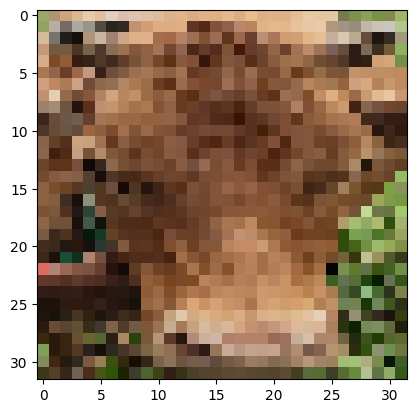

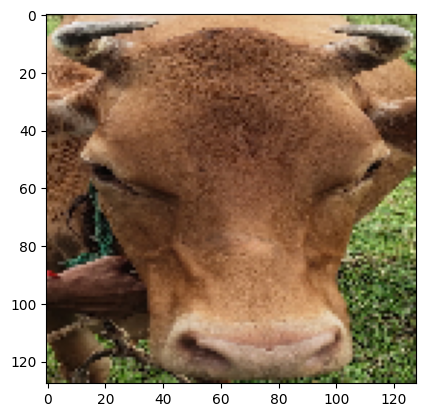

In [25]:
plt.imshow(train_lr[11])
plt.show()
plt.imshow(train_hr[11])
plt.show()

In [26]:
print("train_shape ", train_lr.shape, " test_shape ", test_lr.shape )
print("train_shape ", train_hr.shape, " test_shape ", test_hr.shape )

num_res_block = 16
hr_shape = (train_hr.shape[1], train_hr.shape[2], train_hr.shape[3])
lr_shape = (train_lr.shape[1], train_lr.shape[2], train_lr.shape[3])


Conv2D = layers.Conv2D
BatchNormalization = layers.BatchNormalization
PReLU = layers.PReLU
UpSampling2D = layers.UpSampling2D
Dense = layers.Dense
add = layers.add
LeakyReLU = layers.LeakyReLU
Input = layers.Input
Flatten = layers.Flatten


lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)


train_shape  (80, 32, 32, 3)  test_shape  (20, 32, 32, 3)
train_shape  (80, 128, 128, 3)  test_shape  (20, 128, 128, 3)


In [27]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [28]:
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    
    return disc_model

In [29]:
def create_gen(gen_ip):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [30]:
def create_disc(disc_ip):
    df = 64
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
      
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)
    

In [31]:
from keras.applications import VGG19
def build_vgg(): 
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [32]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip) 
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [38]:
generator = create_gen(lr_ip)
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

vgg = build_vgg()
vgg.trainable = False


gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3, 1], optimizer="adam")

In [37]:
batch_size = 2
train_lr_batches = []
train_hr_batches = []
for it in range(int(train_hr.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(train_hr[start_idx:end_idx])
    train_lr_batches.append(train_lr[start_idx:end_idx])

In [45]:
epochs = 176

for e in range(epochs):
    
    gen_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size,1))
    g_losses = []
    d_losses = []
    for b in range(len(train_hr_batches)):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]
        
        gen_imgs = generator.predict(lr_imgs,verbose=0)
        
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(gen_imgs, gen_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        discriminator.trainable = False
        
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        image_features = vgg.predict(hr_imgs,verbose=0)
        
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    gen_loss.append(g_loss)
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)
    if (e+1) % 25 == 0:
        generator.save_weights("generator_weights_e_"+ str(e+1) +".h5")
        
        generator.save("generator"+str(e+2)+".h5")

epoch: 1 g_loss: 4.795968526601792 d_loss: [4.50956469e-07 1.00000000e+00]
epoch: 2 g_loss: 4.959420573711395 d_loss: [4.28212402e-07 1.00000000e+00]
epoch: 3 g_loss: 4.880314230918884 d_loss: [4.06819876e-07 1.00000000e+00]
epoch: 4 g_loss: 4.746382784843445 d_loss: [3.86496032e-07 1.00000000e+00]
epoch: 5 g_loss: 4.698440176248551 d_loss: [3.67425752e-07 1.00000000e+00]
epoch: 6 g_loss: 4.530198156833649 d_loss: [3.49494597e-07 1.00000000e+00]
epoch: 7 g_loss: 4.416294455528259 d_loss: [3.32616797e-07 1.00000000e+00]
epoch: 8 g_loss: 4.021409964561462 d_loss: [3.1670561e-07 1.0000000e+00]
epoch: 9 g_loss: 3.919329744577408 d_loss: [3.01700827e-07 1.00000000e+00]
epoch: 10 g_loss: 4.1135308861732485 d_loss: [2.87529434e-07 1.00000000e+00]
epoch: 11 g_loss: 4.591492319107056 d_loss: [2.74136954e-07 1.00000000e+00]
epoch: 12 g_loss: 4.9010382235050205 d_loss: [2.61471384e-07 1.00000000e+00]
epoch: 13 g_loss: 5.169356817007065 d_loss: [2.49472379e-07 1.00000000e+00]
epoch: 14 g_loss: 5.1

epoch: 26 g_loss: 4.22303496003151 d_loss: [1.39001571e-07 1.00000000e+00]
epoch: 27 g_loss: 4.052399283647537 d_loss: [1.33092498e-07 1.00000000e+00]
epoch: 28 g_loss: 4.287202709913254 d_loss: [1.27428941e-07 1.00000000e+00]
epoch: 29 g_loss: 4.560147911310196 d_loss: [1.22026636e-07 1.00000000e+00]
epoch: 30 g_loss: 4.48881556391716 d_loss: [1.16881239e-07 1.00000000e+00]
epoch: 31 g_loss: 4.752007806301117 d_loss: [1.11954618e-07 1.00000000e+00]
epoch: 32 g_loss: 4.941966032981872 d_loss: [1.07265238e-07 1.00000000e+00]
epoch: 33 g_loss: 4.708442515134811 d_loss: [1.02776592e-07 1.00000000e+00]
epoch: 34 g_loss: 4.381880223751068 d_loss: [9.84870538e-08 1.00000000e+00]
epoch: 35 g_loss: 4.035792493820191 d_loss: [9.43953737e-08 1.00000000e+00]
epoch: 36 g_loss: 4.077537798881531 d_loss: [9.04849983e-08 1.00000000e+00]
epoch: 37 g_loss: 4.1916064620018005 d_loss: [8.67381801e-08 1.00000000e+00]
epoch: 38 g_loss: 4.044455373287201 d_loss: [8.31556525e-08 1.00000000e+00]
epoch: 39 g_l

KeyboardInterrupt: ignored

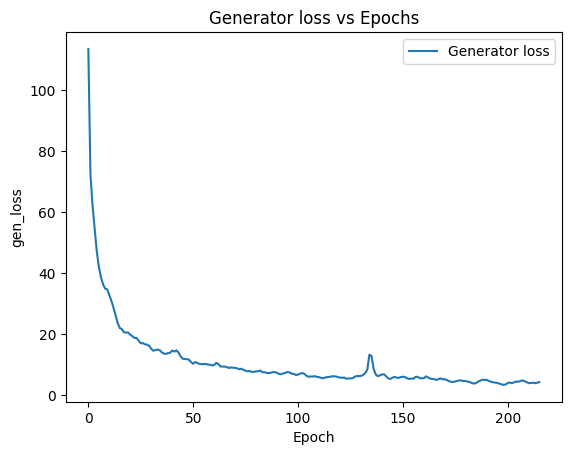

In [46]:
plt.plot(gen_loss, label='Generator loss')
plt.title('Generator loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('gen_loss')
plt.legend()
plt.show()
# print('Avg PSNR =',mean(psnr))

In [47]:
from keras.models import load_model
from numpy.random import randint
import tensorflow as tf
generator = load_model('generator126.h5', compile=False)
res = generator.predict_on_batch(test_lr)


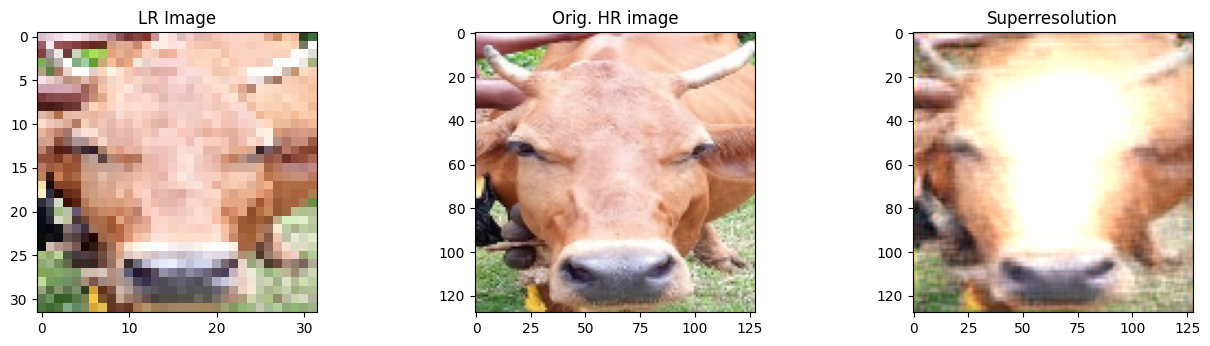

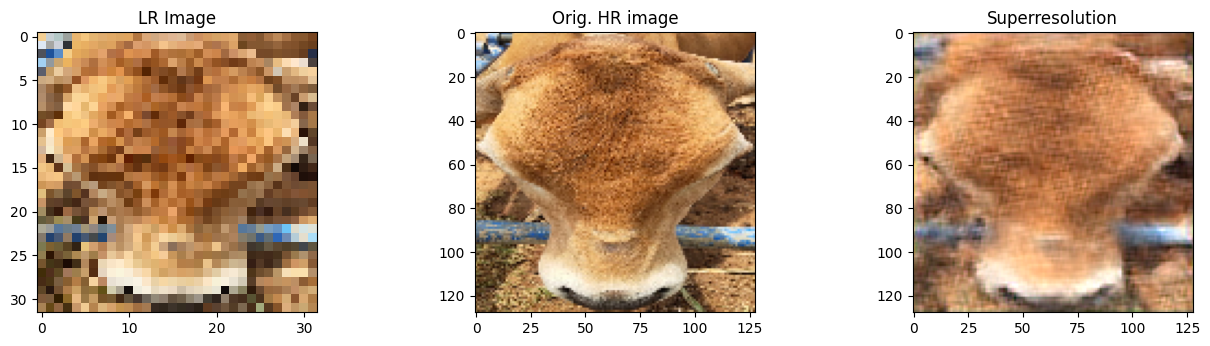

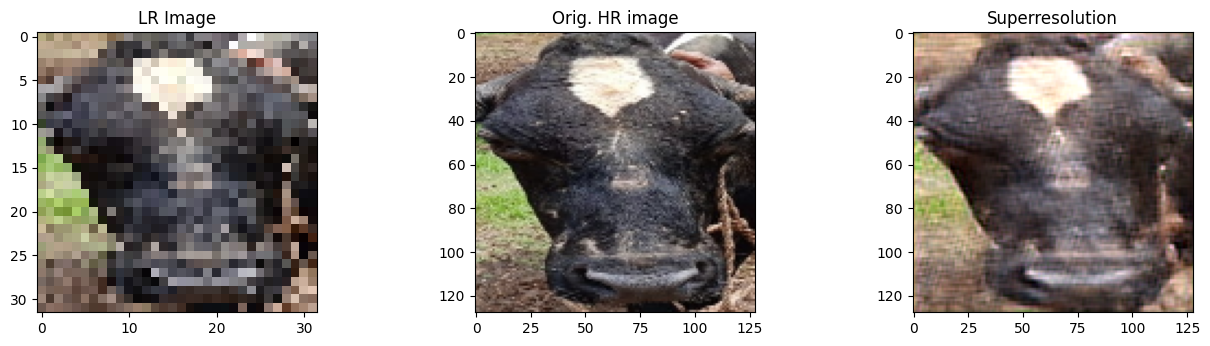

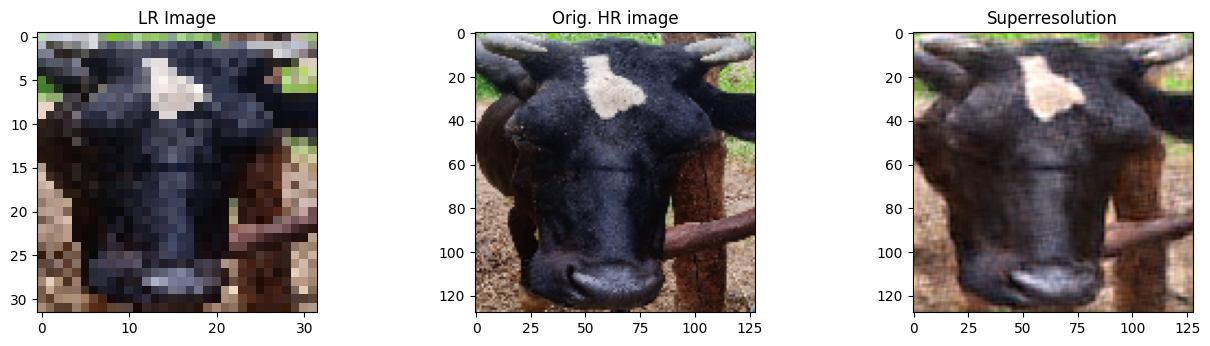

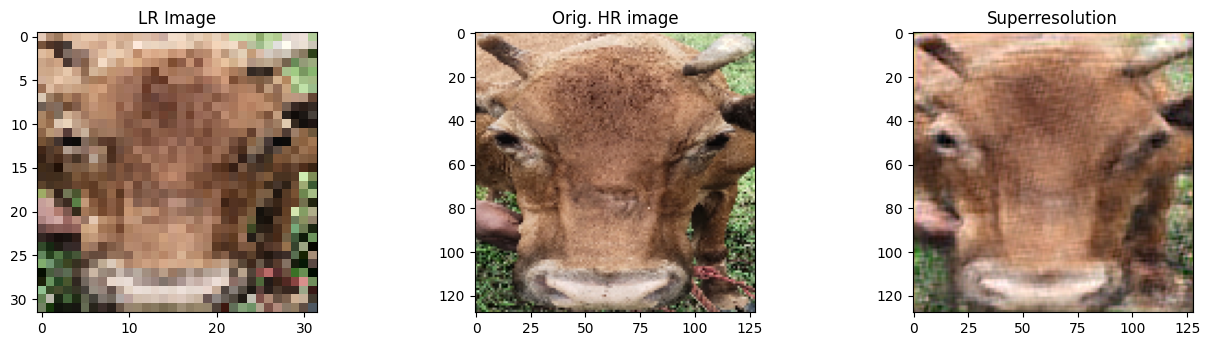

In [48]:
for i in range(0,5):
  ix = randint(0, len(test_lr))
  plt.figure(figsize=(16,8))
  plt.subplot(231)
  plt.title('LR Image')
  plt.imshow(test_lr[ix])
  plt.subplot(232)
  plt.title('Orig. HR image')
  plt.imshow(test_hr[ix])
  plt.subplot(233)
  plt.title('Superresolution')
  plt.imshow(res[ix])

  plt.show()

In [ ]:
from keras.models import load_model
import tensorflow as tf
generator = load_model('generator176.h5', compile=False)
generator.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])

# Define a dictionary to store the training history
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

# Define a callback function to record the training history
class HistoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, batch_size, logs=None):
        history['loss'].append(logs['loss'])
        history['val_loss'].append(logs['val_loss'])
        history['accuracy'].append(logs['accuracy'])
        history['val_accuracy'].append(logs['val_accuracy'])
history = generator.fit(images_lr, images_hr, batch_size=1, epochs=100, validation_split=0.2, callbacks=[HistoryCallback()])




Epoch 1/100
400/400 [==============================] - 42s 37ms/step - loss: 0.0557 - accuracy: 0.6316 - val_loss: 0.0516 - val_accuracy: 0.6577
Epoch 2/100
400/400 [==============================] - 13s 33ms/step - loss: 0.0508 - accuracy: 0.6408 - val_loss: 0.0576 - val_accuracy: 0.5840
Epoch 3/100
400/400 [==============================] - 13s 32ms/step - loss: 0.0497 - accuracy: 0.6378 - val_loss: 0.0535 - val_accuracy: 0.6290
Epoch 4/100
400/400 [==============================] - 13s 33ms/step - loss: 0.0520 - accuracy: 0.6151 - val_loss: 0.0581 - val_accuracy: 0.8093
Epoch 5/100
400/400 [==============================] - 13s 32ms/step - loss: 0.0476 - accuracy: 0.6330 - val_loss: 0.0544 - val_accuracy: 0.5733
Epoch 6/100
400/400 [==============================] - 13s 33ms/step - loss: 0.0467 - accuracy: 0.6428 - val_loss: 0.0542 - val_accuracy: 0.7883
Epoch 7/100
400/400 [==============================] - 13s 33ms/step - loss: 0.0457 - accuracy: 0.6307 - val_loss: 0.0580 - val_ac

In [ ]:
res = generator.predict(images_lr)

16/16 [==============================] - 2s 118ms/step


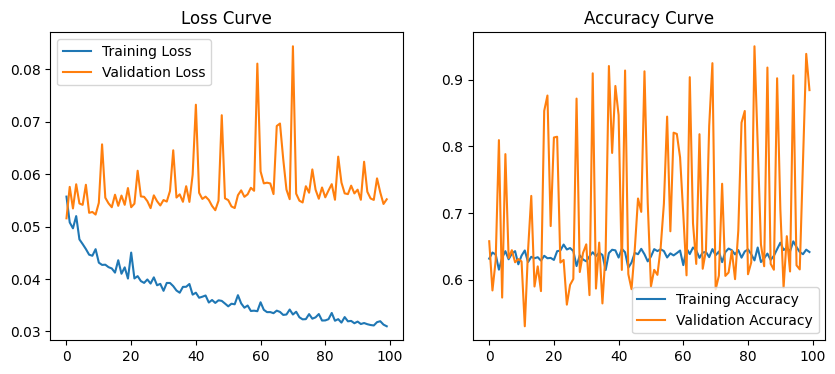

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss Curve')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy Curve')
axs[1].legend()

plt.show()

In [ ]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means that no noise is present in the signal .
                  # Therefore PSNR has no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [ ]:
from math import log10, sqrt
psnr = [PSNR(images_hr[i], res[i]) for i in range(len(images_hr))]

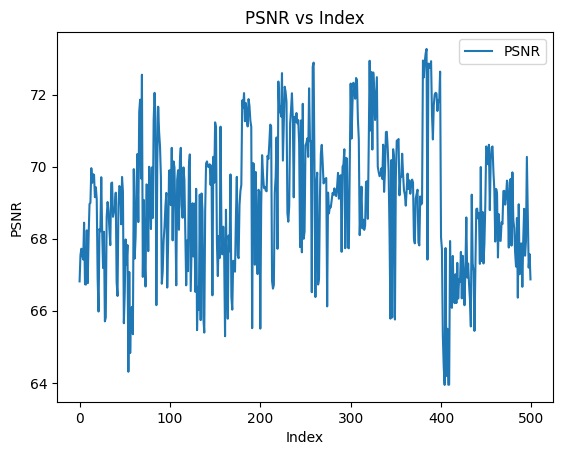

Avg PSNR = 69.02762459425425


In [ ]:

from statistics import mean
plt.plot(psnr, label='PSNR')
plt.title('PSNR vs Index')
plt.xlabel('Index')
plt.ylabel('PSNR')
plt.legend()
plt.show()
print('Avg PSNR =',mean(psnr))


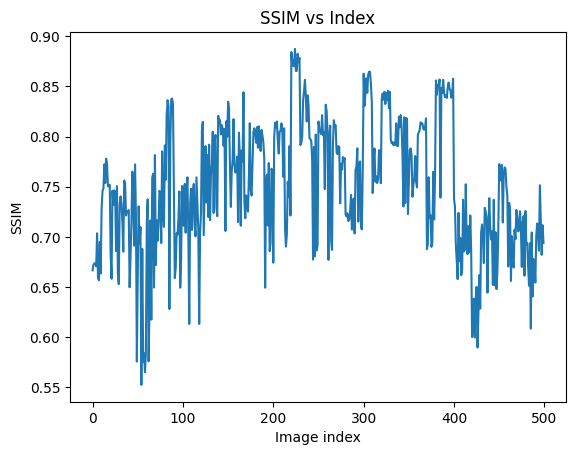

Avg SSIM = 0.7499943866194072


In [ ]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

ssim_values = []
sum=0
for i in range(len(images_hr)):
    s = ssim(images_hr[i], res[i], channel_axis=2)
    ssim_values.append(s)
    sum+=s

plt.plot(ssim_values)
plt.title('SSIM vs Index')
plt.xlabel('Image index')
plt.ylabel('SSIM')
plt.show()
print('Avg SSIM =',sum/len(images_hr))